## This will be the codebase for the dictionary learning portion

### Source Code for sklearn : https://github.com/scikit-learn/scikit-learn

In [1]:
from sklearn.feature_extraction import image as image_extractor
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import SparseCoder
from skimage import io
import matplotlib.pyplot as plt
from scipy import ndimage
import csv
import numpy as np
import distutils
from distutils import util
import pdb
import dictlearn as dl

In [2]:
"""
First order discretization (linear voting in time)
    events in t,x,y,pol  numpy array
    Assume x and y are integer coordinates
    img_size: for example (180,240) for the DAVIS240C
    num_bins_t: 3-9
"""
def events2voxelgrid_linear(x,y,timestamp,pol, img_size, num_bins_t, t_min, dt_cell, use_polarity=True):
    assert len(x) == len(y) == len(pol) == len(timestamp)
    num_events = len(x)
    # creates a (180,240,5) matrix to store the 5 event frames - each frame will have both positive and negative events
    voxelgrid = np.zeros(img_size+(num_bins_t,), np.float64)
    for i in range(num_events-1):
        tn = (timestamp[i] - t_min) / dt_cell
        ti = int(tn)
        dt = tn - ti
        # Voting on two adjacent cells
        polarity = (2.*pol[i] - 1.) if use_polarity else 1.
        voxelgrid[y[i],x[i],ti] += (1. - dt)*polarity
        if ti < num_bins_t-1:
            voxelgrid[y[i],x[i],ti+1] += dt*polarity
    print(np.sum(np.abs(voxelgrid))) # This should equal the number of events
    return voxelgrid.astype('float32')

### Parameters of the method

In [3]:
patch_size = (5, 5)
max_patches = 80004  # Due to memory issues

# Event parameters: the number of events to be taken into consideration
num_time_slices = 5

# Method to compute voxel grids of events (time slices): nearest neighbor or linear voting
method_voting = 'Linear'

# Split by polarity (double grid size) or not?
split_by_polarity = True

# number of gradient components 
num_gradient_component = 2

num_patches_per_component = max_patches/(2*num_time_slices + num_gradient_component)

# Dictionary
n_components = 1000

### Read the image

In [4]:
image = io.imread("0.210521.png",as_gray=True).astype('float32')

Load as grayscale image (because we know that the image has no color), and also convert to floating point, to operate on real numbers, not on integers.

In [5]:
image.shape

(260, 346)

In [6]:
image.dtype

dtype('float32')

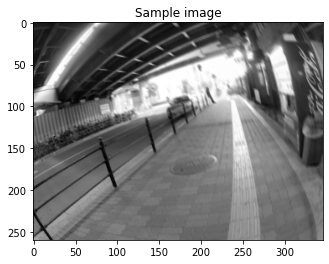

In [7]:
plt.imshow(image, cmap='gray')
plt.title('Sample image')
plt.show()

### Calculate the X and Y derivative using sobel operator. This is very good with edge detection

In [8]:
image_x = ndimage.sobel(image, axis=0).astype('float32')
image_y = ndimage.sobel(image, axis=1).astype('float32')

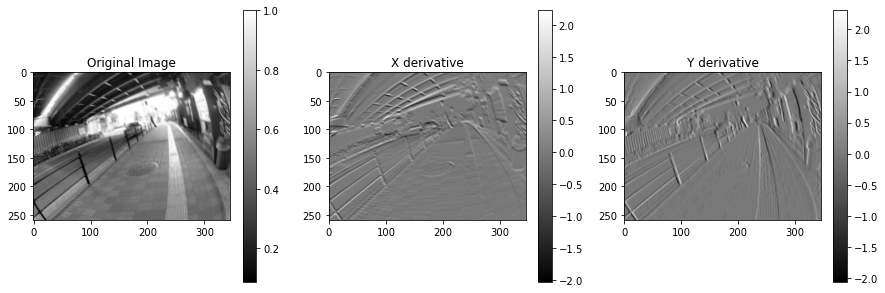

In [9]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5), sharex = True)

p1 = ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
plt.colorbar(p1,ax=ax1)

p2 = ax2.imshow(image_x, cmap='gray')
ax2.set_title('X derivative')
plt.colorbar(p2,ax=ax2)

p3 = ax3.imshow(image_y, cmap='gray')
ax3.set_title('Y derivative')
plt.colorbar(p3,ax=ax3)

plt.show()

## Create the event histogram

Read events

In [10]:
# read the file and store it in different arrays 
timestamp = []
x = []
y = []
pol = []

with open('event_data.csv') as csvfile:
    event_file = csv.reader(csvfile, delimiter=',')
    next(event_file)
    for row in event_file:
        if len(row) == 0:
            continue; # while writing, an additional alternative empty row is written in the excel. so skippping
        x.append(int(row[0]))
        y.append(int(row[1]))
        timestamp.append(float(row[2]))
        pol.append(distutils.util.strtobool(row[3]))
        
assert len(x) == len(y) == len(pol) == len(timestamp)

In [11]:
total_num_events = len(x)

In [12]:
total_num_events

39969

In [13]:
# convert to arrays
x = np.array(x)
y = np.array(y)
timestamp = np.array(timestamp)
pol = np.array(pol)

In [14]:
#dividing the events into equal chunks of time
t_max = np.amax(timestamp)
t_min = np.amin(timestamp)
t_range = t_max - t_min
dt_cell = t_range / num_time_slices
t_edges = np.linspace(t_min,t_max,num_time_slices+1) # boundaries of the cells; not needed

# Specify bin edges in each dimension
bin_edges = (np.linspace(0,image.shape[0],image.shape[0]+1), 
             np.linspace(0,image.shape[1],image.shape[1]+1), t_edges)

In [15]:
if not split_by_polarity:
    # one voxel grid for all events (both polarities)
    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt = np.transpose(np.array([y, x, timestamp]))
        voxelgrid, _ = np.histogramdd(yxt, bins=bin_edges).astype('float32')
        del yxt
    else:
        print('Interpolated histogram')
        voxelgrid = events2voxelgrid_linear(x,y,timestamp,pol, 
                                            image.shape,num_time_slices,t_min,dt_cell,use_polarity=True)
    print(voxelgrid.shape)

    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    for i in range(voxelgrid.shape[2]):
        plt.sca(axs[int(i/2),i%2])
        plt.imshow(voxelgrid[:,:,i], cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
    axs.flat[-1].set_visible(False)
    plt.suptitle("Event Frames")
    plt.show()


Interpolated histogram
19002.965777732683
(260, 346, 5)


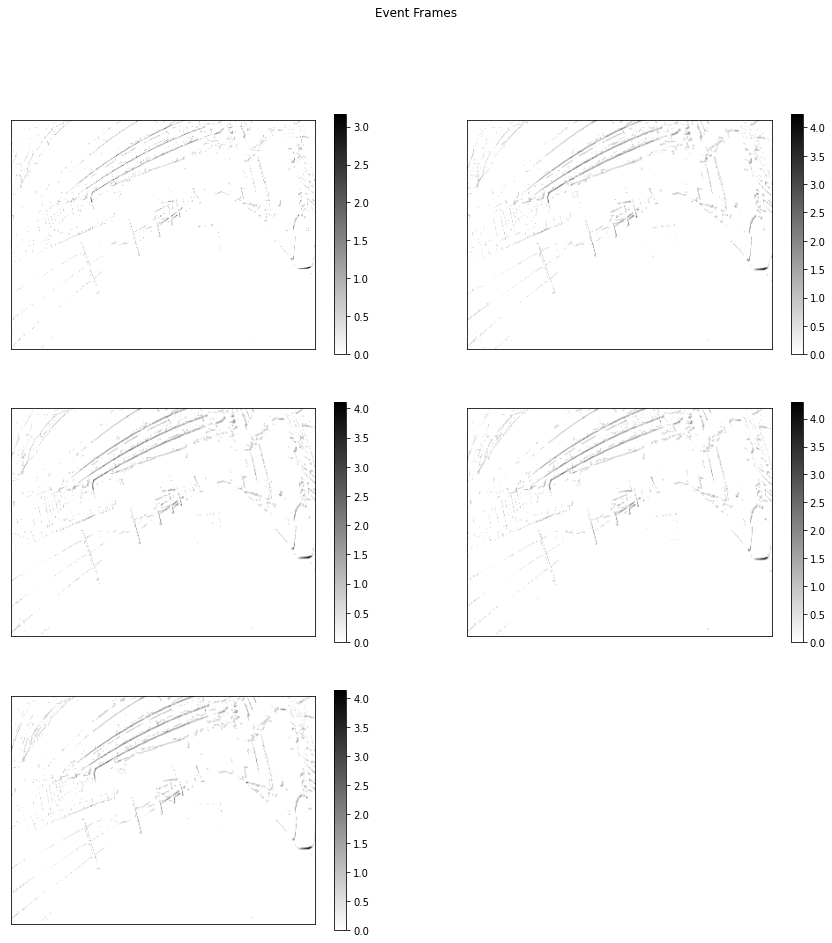

In [16]:
if split_by_polarity:
    # Positive events only
    idx_pos = pol==0

    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt_pos = np.transpose(np.array([y[idx_pos], x[idx_pos], timestamp[idx_pos]]))
        voxelgrid_pos, _ = np.histogramdd(yxt_pos, bins=bin_edges).astype('float32')
        del yxt_pos
    else:
        print('Interpolated histogram')
        voxelgrid_pos = events2voxelgrid_linear(x[idx_pos],y[idx_pos],timestamp[idx_pos],pol[idx_pos], 
                                                image.shape,num_time_slices,t_min,dt_cell,use_polarity=False)
    print(voxelgrid_pos.shape)
    
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    for i in range(voxelgrid_pos.shape[2]):
        plt.sca(axs[int(i/2),i%2])
        plt.imshow(voxelgrid_pos[:,:,i], cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
    axs.flat[-1].set_visible(False)
    plt.suptitle("Event Frames")
    plt.show()

Interpolated histogram
16910.944302496322
(260, 346, 5)


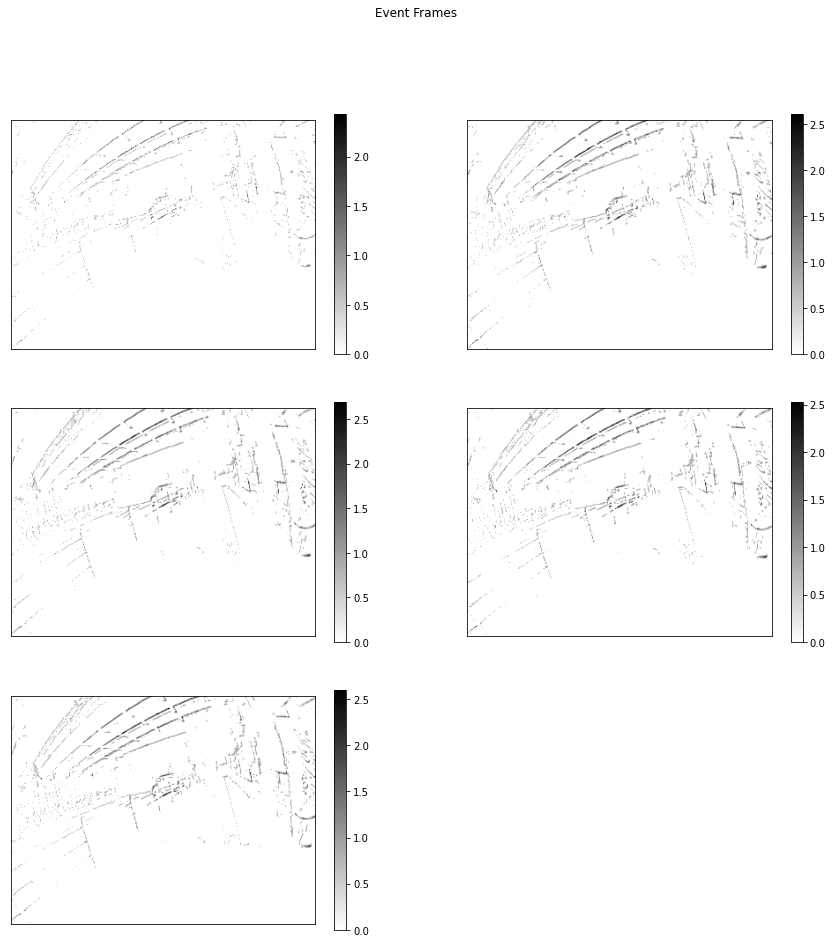

In [17]:
if split_by_polarity:
    # Negative events only
    idx_neg = pol!=0

    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt_neg = np.transpose(np.array([y[idx_neg], x[idx_neg], timestamp[idx_neg]]))
        voxelgrid_neg, _ = np.histogramdd(yxt_neg, bins=bin_edges).astype('float32')
        del yxt_neg
    else:
        print('Interpolated histogram')
        voxelgrid_neg = events2voxelgrid_linear(x[idx_neg],y[idx_neg],timestamp[idx_neg],pol[idx_neg], 
                                                image.shape,num_time_slices,t_min,dt_cell,use_polarity=False)
    print(voxelgrid_neg.shape)
    
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    for i in range(voxelgrid_neg.shape[2]):
        plt.sca(axs[int(i/2),i%2])
        plt.imshow(voxelgrid_neg[:,:,i], cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
    axs.flat[-1].set_visible(False)
    plt.suptitle("Event Frames")
    plt.show()

It is a bit more complicated: I think it is better that the chuncks have equal time span $\Delta t$, rather than equal number of events. See the code from Ex 2 in the course to create the voxel grids.

### Creating the matrix X for dictionary learning

In [18]:
print(num_patches_per_component)

6667.0


So the Matrix is a 2D matrix with the following the following dimension :  (2n +2nm) X num_patches_per_component. Here, n is number of pixels in a patch which will be 5X5 = 25 and m is number of events. 

In [19]:
# creating patch for x gradient
patches_x = image_extractor.extract_patches_2d(
        image_x, patch_size, int(num_patches_per_component))
patches_x = patches_x.reshape((int(num_patches_per_component),patch_size[0]*patch_size[1]))
patches_x = patches_x.T

# creating patch for y gradient
patches_y = image_extractor.extract_patches_2d(
        image_y, patch_size, int(num_patches_per_component))
patches_y = patches_y.reshape((int(num_patches_per_component),patch_size[0]*patch_size[1]))
patches_y = patches_y.T

if split_by_polarity:
    # creating patch of positive events 
    for i in range(num_time_slices):
        patches_p = image_extractor.extract_patches_2d(voxelgrid_pos[:,:,i], patch_size, int(num_patches_per_component))
        patches_p = patches_p.reshape((int(num_patches_per_component),patch_size[0]*patch_size[1]))
        patches_p = patches_p.T
        if(i == 0):
            patches_pos = patches_p
        else:
            patches_pos = np.vstack((patches_pos,patches_p))
            print(patches_pos.shape)
    
    for i in range(num_time_slices):
        # creating patch of negative events
        patches_n = image_extractor.extract_patches_2d(voxelgrid_neg[:,:,i], patch_size, int(num_patches_per_component))
        patches_n = patches_n.reshape((int(num_patches_per_component),patch_size[0]*patch_size[1]))
        patches_n = patches_n.T
        if(i == 0):
            patches_neg = patches_n
        else:
            patches_neg = np.vstack((patches_neg,patches_n))
        
X = np.vstack((patches_x,patches_y,patches_pos,patches_neg))
print(X.shape)
    




(50, 6667)
(75, 6667)
(100, 6667)
(125, 6667)
(300, 6667)


C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass max_patches=6667 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass max_patches=6667 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass max_patches=6667 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass max_patches=6667 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\sudes\softwares\Anaconda3\lib\site-packages\skl

In [20]:
X.dtype

dtype('float32')

#### TODO : How to visualise the patches ? With the changes I have made ?

In [21]:
print('Learning the dictionary...')
dictionary = dl.random_dictionary(300, 6667)
# cannot use dct_dict as error with ram allocation

Learning the dictionary...


In [22]:
dictionary,_ = dl.ksvd(X, dictionary, 50, n_nonzero=8,n_threads=4, verbose=True)


K-SVD iteration 1/50
  OMP: Finding sparse decomposition...DONE
  K-SVD: Updating dictionary...DONE
K-SVD iteration 2/50
  OMP: Finding sparse decomposition...DONE
  K-SVD: Updating dictionary...DONE
K-SVD iteration 3/50
  OMP: Finding sparse decomposition...DONE
  K-SVD: Updating dictionary...DONE
K-SVD iteration 4/50
  OMP: Finding sparse decomposition...DONE
  K-SVD: Updating dictionary...DONE
K-SVD iteration 5/50
  OMP: Finding sparse decomposition...DONE
  K-SVD: Updating dictionary...DONE
K-SVD iteration 6/50
  OMP: Finding sparse decomposition...DONE
  K-SVD: Updating dictionary...DONE
K-SVD iteration 7/50
  OMP: Finding sparse decomposition...DONE
  K-SVD: Updating dictionary...DONE
K-SVD iteration 8/50
  OMP: Finding sparse decomposition...DONE
  K-SVD: Updating dictionary...DONE
K-SVD iteration 9/50
  OMP: Finding sparse decomposition...DONE
  K-SVD: Updating dictionary...DONE
K-SVD iteration 10/50
  OMP: Finding sparse decomposition...DONE
  K-SVD: Updating dictionary...DONE

In [23]:
type(dictionary)

numpy.ndarray

In [25]:

dictionary.shape

(300, 6667)

In [26]:
dictionary.shape

(300, 6667)

In [27]:
dl.visualize_dictionary(dictionary, 5, 5)

ValueError: cannot reshape array of size 300 into shape (17,17)

In [34]:
int(np.sqrt(dictionary[0])) + 2

C:\Users\sudes\softwares\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


TypeError: only size-1 arrays can be converted to Python scalars

Visualize the atoms:

ValueError: cannot reshape array of size 6667 into shape (5,5,newaxis)

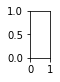

In [23]:
num_atoms_plot = 40
if (num_atoms_plot > n_components):
    num_atoms_plot = n_components

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:num_atoms_plot]):
    plt.subplot(int(num_atoms_plot/10), 10, i + 1)
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    plt.imshow(atom[:,:,0], cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned. Gx\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

In [ ]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:num_atoms_plot]):
    plt.subplot(int(num_atoms_plot/10), 10, i + 1)
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    plt.imshow(atom[:,:,2], cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned. Events slice 0\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

In [ ]:
plt.figure(figsize=(4,num_atoms_plot*0.5))
for i, comp in enumerate(V[:num_atoms_plot]):
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    for j in range(data.shape[2]):
        plt.subplot(num_atoms_plot, data.shape[2], data.shape[2]*i + j + 1)
        plt.imshow(atom[:,:,j], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
plt.suptitle('Dictionary learned. One row per atom\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

Part of the dictionary corresponding to the spatial gradients (the upper part of V)

In [ ]:
num_elem_grads = 2*patch_size[0]*patch_size[1]
V_gradients = V[:,:num_elem_grads]
V_gradients.shape

Part of the dictionary corresponding to the events (the bottom part of V)

In [ ]:
V_events = V[:,num_elem_grads:]
V_events.shape

In [ ]:
dico

In [ ]:
data_test = image_extractor.extract_patches_2d(voxelgrid, patch_size)
data_test.shape

In [ ]:
data_test = data_test.reshape(data_test.shape[0], -1)
data_test.shape

In [ ]:
#n_coefs = 10
#coder = SparseCoder(dictionary=V_events, transform_algorithm='omp', transform_n_nonzero_coefs=n_coefs)
coder = SparseCoder(dictionary=V_events, transform_algorithm='omp')

In [ ]:
np.transpose(data_test).shape

In [ ]:
code = coder.transform(data_test)
code.shape

In [ ]:
patches_g = np.dot(code, V_gradients)
patches_g.shape

In [ ]:
patches_g = patches_g.reshape(patches_g.shape[0],patch_size[0],patch_size[1],2)
patches_g.shape

In [ ]:
reconstruction = image_extractor.reconstruct_from_patches_2d(patches_g, (image.shape[0],image.shape[1],2))
reconstruction.shape

In [ ]:
plt.imshow(reconstruction[:,:,0], cmap='gray')
plt.title('Recovered gradient X')
plt.show()

In [ ]:
plt.imshow(reconstruction[:,:,1], cmap='gray')
plt.title('Recovered gradient Y')
plt.show()

In [ ]:
plt.imshow(image_y, cmap='gray')
plt.title('Original gradient Y')
plt.show()

TO DO: 
- [x] compute histograms (Ep,En) using linear voting instead of regular voting
- [x] test with a single voxel grid (with polarity), instead of two (Ep,En)
- [x] better plot the dictionaty. One atom per row
- [x] reconstruction with the learned dictionary
- are gx,gy dominating the largest components? Or are all dimensions independent? Do we need to rescale?
- debug reconstruction. Results do not look good.